In [1]:
import numpy as np 
import pandas as pd
import pandas_profiling as pp

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import svm

from sklearn.metrics import accuracy_score
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Reading Data:

In [2]:
#Get Columns Names and Convert Them To List
column=pd.read_csv("train_col_name.csv", header=None)
column=list(column[0])
#Read Dataset
df=pd.read_csv("train.csv",header=None, names=column)

#Read label and Merge Them With df
label=pd.read_csv("train_lable.csv",header=None)
df["label"]=label

In [3]:
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,B1,B2,...,J9,J10,J11,J12,J13,J14,J15,J16,K,label
0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
2,0,0,0,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1


# EDA:

In [4]:
#Generating Report From Pandas Profiling
rep=pp.ProfileReport(df)
rep

In [5]:
#Save Report To File
rep.to_file(output_file="Dataset_EDA.html")

In [6]:
#Generating Report for customers who will not Churn
Nchurn=df.query('label==0')
rep1=pp.ProfileReport(Nchurn)
rep1

In [7]:
rep1.to_file(output_file="EDA_label=0.html")

In [8]:
#Generating Report for customers who will
churn=df.query('label==1')
rep2=pp.ProfileReport(churn)
rep2

In [9]:
rep2.to_file(output_file="EDA_label=1.html")

# Applying model with 37 features:

In [10]:
X = df.iloc[:,0:37]
y = df.iloc[:,-1] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=20)

In [11]:
RFC0= RandomForestClassifier(random_state=20)
RFC0.fit(X_train, y_train)

y_pred = RFC0.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.70%


# Recursive feature elimination with cross-validation:

Recursive Feature Elimination Cross-Validated (RFECV) feature selection which selects the best subset of features using recursive feature elimination and then selecting the best subset based on the cross-validation score of the model. 

Optimal number of features : 7


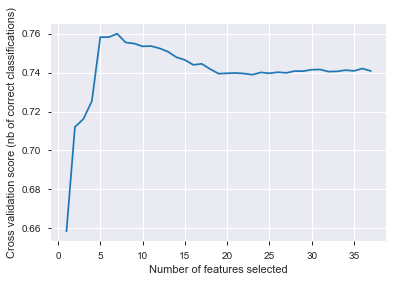

In [12]:
rfe = RFECV(RandomForestClassifier(n_estimators=100, random_state=20, n_jobs=-1), step=1,  cv=StratifiedKFold(2),
            scoring='accuracy')

rfe.fit(X, y)

print("Optimal number of features : %d" % rfe.n_features_)

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [13]:
features = X.columns[rfe.get_support()]
rfe.get_support()

array([False, False, False, False, False, False, False, False,  True,
        True, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
        True])

In [14]:
features

Index(['B1', 'B2', 'C1', 'C2', 'J12', 'J16', 'K'], dtype='object')

# Models:

###### With 7 Features selected from RFECV

In [15]:
X = df[features]
y = df.iloc[:,-1] 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=20)

### SVM

In [17]:
clf = svm.SVC(coef0=1.0,random_state=20)
clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=1.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=20,
    shrinking=True, tol=0.001, verbose=False)

In [18]:
accuracy=clf.score(X_test,y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.30%


### RandomForestClassifier

In [19]:
RFC = RandomForestClassifier(random_state=20)
RFC.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)

In [20]:
y_pred=RFC.predict(X_test)
accuracy=metrics.accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.76%


### XGBClassifier

In [21]:
XGB = XGBClassifier(random_state=20)
XGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=20, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [22]:
y_pred = XGB.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.74%


# TOP N Features:

In [23]:
n=5

In [24]:
X = df.iloc[:,0:37]
y = df.iloc[:,-1] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=20)

In [25]:
sel = RFE(RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1), n_features_to_select = n)
sel.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                     criterion='gini', max_depth=None,
                                     max_features='auto', max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=100, n_jobs=-1,
                                     oob_score=False, random_state=0, verbose=0,
                                     warm_start=False),
    n_features_to_select=5, step=1, verbose=0)

In [26]:
features = X.columns[sel.get_support()]

In [27]:
features

Index(['B2', 'C2', 'J12', 'J16', 'K'], dtype='object')

In [28]:
X = df[features]
y = df.iloc[:,-1] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=20)

In [29]:
RFCZ= RandomForestClassifier(random_state=20)
RFCZ.fit(X_train, y_train)

y_pred = RFCZ.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.31%


# References

1. https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py
2. https://github.com/laxmimerit/Recursive-Feature-Elimination-RFE-by-Using-Tree-Based-and-Gradient-Boosting-Algorithm/blob/master/Recursive%20Feature%20Selection%20by%20Using%20Tree%20Based%20and%20Gradient%20Based%20Estimators%20.ipynb
3. https://github.com/pandas-profiling/pandas-profiling
4. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
5. https://xgboost.readthedocs.io/en/latest/python/python_api.html
6. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
